In [ ]:
import pandas as pd
import numpy as np
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import regex as re
from nltk.stem import SnowballStemmer
from scipy import sparse
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score,recall_score,confusion_matrix, roc_curve,auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df = pd.read_csv('FinalBalancedDataset.csv')
df.drop(['Unnamed: 0'], axis=1,inplace=True)
Target = pd.DataFrame(df['Toxicity'])
tweets = pd.DataFrame(df['tweet'])

In [ ]:
tokenized_data=[]
for each in tweets['tweet']:
    tokenized_data.append(word_tokenize(each.lower()))

In [ ]:
sb = SnowballStemmer('english')
sw = stopwords.words('english')
stemmed_data=[]
for each in tokenized_data:
    ind_list_stemmed=[]
    for each_word in each:
        if each_word not in sw and re.findall('[A-Za-z]',each_word):
            ind_list_stemmed.append(sb.stem(each_word))
    stemmed_data.append(ind_list_stemmed)

In [ ]:
stemmed_strings=[]
for each in stemmed_data:
    stemmed_strings.append(' '.join(each))


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
cv_df = pd.DataFrame(cv.fit_transform(stemmed_strings).todense(),columns= sorted(cv.vocabulary_))

In [ ]:
not_useful_columns_cv=[]
for each_column in cv.vocabulary_:
  if  not(((cv_df[each_column] > 1).sum()) > 0) :
    not_useful_columns_cv.append(each_column)

In [ ]:
len(not_useful_columns_cv)

54697

In [ ]:
cv_after_removing = cv_df.drop(not_useful_columns_cv, axis=1)
dense_matrix_cv= cv_after_removing.values
sparse_matrix_cv = sparse.csr_matrix(dense_matrix_cv)

In [ ]:
sparse_matrix_cv.shape

(56745, 3570)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf_df = pd.DataFrame(tfidf.fit_transform(stemmed_strings).todense(),columns= sorted(tfidf.vocabulary_))

In [ ]:
not_useful_columns_tfidf=[]
for each_column in tfidf.vocabulary_:
  if  not(((tfidf_df[each_column] > 0).sum()) > 5) :
    not_useful_columns_tfidf.append(each_column)

In [ ]:
len(not_useful_columns_tfidf)

51575

In [ ]:
tfidf_after_removing = tfidf_df.drop(not_useful_columns_tfidf, axis=1)
dense_matrix_tfidf= tfidf_after_removing.values
sparse_matrix_tfidf = sparse.csr_matrix(dense_matrix_tfidf)

In [ ]:
del tfidf_df
del tfidf_after_removing
del cv_df
del not_useful_columns_tfidf
del dense_matrix_cv
del dense_matrix_tfidf

In [ ]:
sparse_matrix_tfidf.shape

(56745, 6692)

**Bag of word(Count Vectorizer)**

In [ ]:
from sklearn.model_selection import train_test_split
x_train_cv, x_test_cv, y_train_cv, y_test_cv = train_test_split(sparse_matrix_cv,Target,train_size=0.7)

x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(sparse_matrix_tfidf,Target,train_size=0.7)



In [ ]:
x_test_tfidf.shape

(17024, 6692)

In [ ]:
y_test_tfidf.shape

(17024, 1)

**Standardization**

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler(with_mean=False)
xb_train = ss.fit_transform(x_train_cv)
xb_test = ss.transform(x_test_cv)

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler(with_mean=False)
xt_train = ss.fit_transform(x_train_tfidf)
xt_test = ss.transform(x_test_tfidf)

**Metrics Function**

In [ ]:
def metrics(train_accuracy,preds,y_test,proba):
    print("train acuuracy:",train_accuracy)
    print("test acuuracy:",accuracy_score(preds,y_test))
    print("Recall:",recall_score(y_test,preds,average='macro'))
    print("Precision:",precision_score(y_test,preds,average='macro'))

    cm = confusion_matrix(preds,y_test)
    plt.figure(figsize=[7,6])
    sns.heatmap(cm, cmap="Reds", annot=True, fmt='.0f')
    plt.title("Confusion-Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


    y_test_bin = label_binarize(y_test,classes=range(2))
    fpr,tpr,thersholds = roc_curve(y_test,preds)
    auc_ = auc(fpr,tpr)
    print('\n')
    plt.plot(fpr,tpr,label =f'auc={round(auc_,2)}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate(FPR)")
    plt.ylabel("True Positive Rate(TPR)")
    plt.grid(True)
    plt.legend()
    plt.show()

**Navie bayes(Bag of words)**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
nbclassifier = MultinomialNB()
skf = StratifiedKFold(n_splits = 5)

params_nb = {'alpha': [1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
          }

rcv_nb_cv = RandomizedSearchCV(nbclassifier,param_distributions=params_nb,cv=skf,scoring='accuracy')
rcv_nb_cv.fit(x_train_cv,y_train_cv)



RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=MultinomialNB(),
                   param_distributions={'alpha': [1e-09, 1e-08, 1e-07, 1e-06,
                                                  1e-05, 0.0001, 0.001, 0.01,
                                                  0.1]},
                   scoring='accuracy')

In [ ]:
final_model_nb_cv = nbclassifier.set_params(**rcv_nb_cv.best_params_)
final_model_nb_cv.fit(x_train_cv,y_train_cv)
preds_nb_cv= final_model_nb_cv.predict(x_test_cv)
proba_nb_cv= final_model_nb_cv.predict_proba(x_test_cv)

train acuuracy: 0.9057173689710922
test acuuracy: 0.9051926691729323
Recall: 0.9056641924416557
Precision: 0.9019040882793885


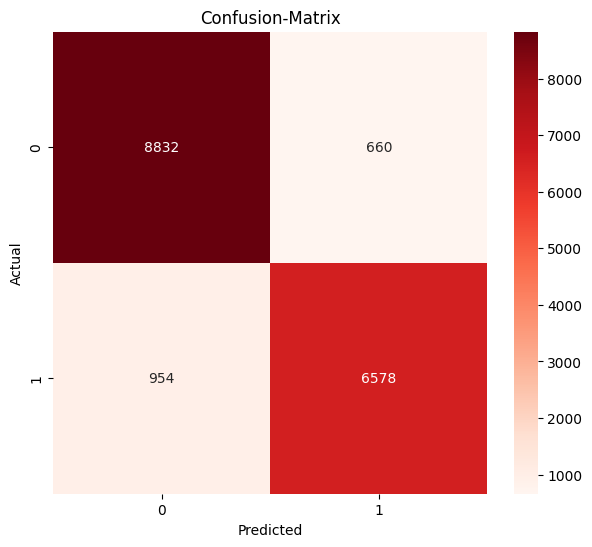

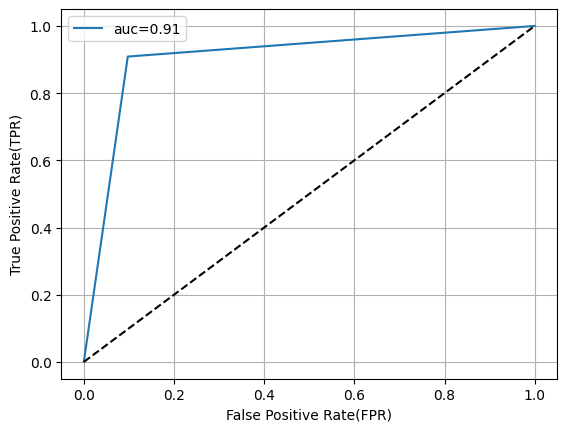

In [ ]:
metrics(rcv_nb_cv.best_score_,preds_nb_cv,y_test_cv,proba_nb_cv)


**Navie Bayes(Tfidf)**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nbclassifier = MultinomialNB()
skf = StratifiedKFold(n_splits = 5)

params_nb = {'alpha': [1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]
          }

rcv_nb_tfidf = RandomizedSearchCV(nbclassifier,param_distributions=params_nb,cv=skf,scoring='accuracy')
rcv_nb_tfidf.fit(x_train_tfidf,y_train_tfidf)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=MultinomialNB(),
                   param_distributions={'alpha': [1e-09, 1e-08, 1e-07, 1e-06,
                                                  1e-05, 0.0001, 0.001, 0.01,
                                                  0.1]},
                   scoring='accuracy')

In [ ]:
final_model_nb_tfidf = nbclassifier.set_params(**rcv_nb_tfidf.best_params_)
final_model_nb_tfidf.fit(x_train_tfidf,y_train_tfidf)
preds_nb_tfidf= final_model_nb_tfidf.predict(x_test_tfidf)
proba_nb_tfidf= final_model_nb_tfidf.predict_proba(x_test_tfidf)

train acuuracy: 0.9081593780757309
test acuuracy: 0.9080122180451128
Recall: 0.9073423656080937
Precision: 0.9050317298097925


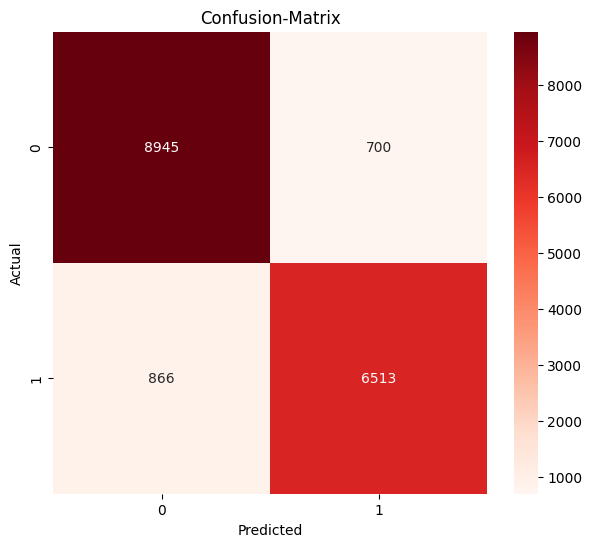

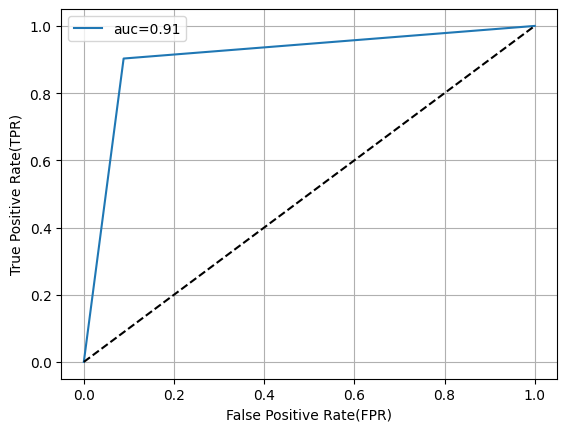

In [ ]:
metrics(rcv_nb_tfidf.best_score_,preds_nb_tfidf,y_test_tfidf,proba_nb_tfidf)

**K-NN Classifier(Bag of Words)**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
knn = KNeighborsClassifier()
skf = StratifiedKFold(n_splits = 5)
knn = KNeighborsClassifier()
params_knn ={'n_neighbors': range(0,10),
             'weights': ['uniform','distance'],
             'metric':['manhattan','euclidean','cosine'],}
rcv_knn = RandomizedSearchCV(knn, param_distributions=params_knn,cv=skf,scoring = 'accuracy')
rcv_knn.fit(x_train_cv,y_train_cv)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=KNeighborsClassifier(),
                   param_distributions={'metric': ['manhattan', 'euclidean',
                                                   'cosine'],
                                        'n_neighbors': range(0, 10),
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy')

In [ ]:
rcv_knn.best_params_

{'weights': 'uniform', 'n_neighbors': 7, 'metric': 'manhattan'}

In [ ]:
rcv_knn.best_score_

0.9114322028903394

In [ ]:
final_model_knn = knn.set_params(**rcv_knn.best_params_)
final_model_knn.fit(x_train_cv,y_train_cv)
preds_knn= final_model_knn.predict(x_test_cv)
proba_knn= final_model_knn.predict_proba(x_test_cv)

train acuuracy: 0.9114322028903394
test acuuracy: 0.9127114661654135
Recall: 0.9036965530436447
Precision: 0.9190541870835399


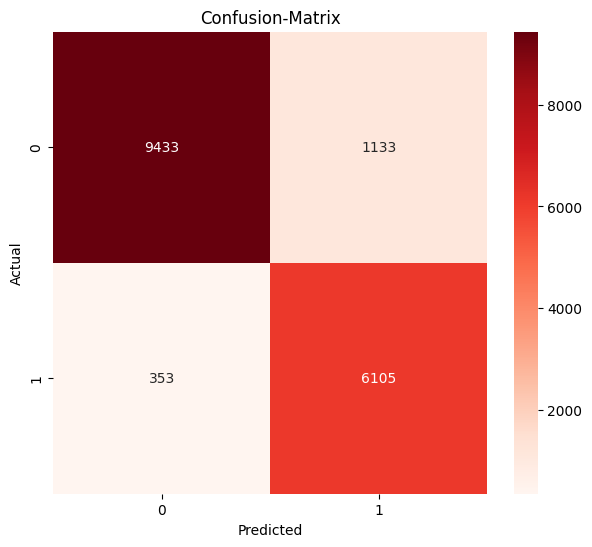

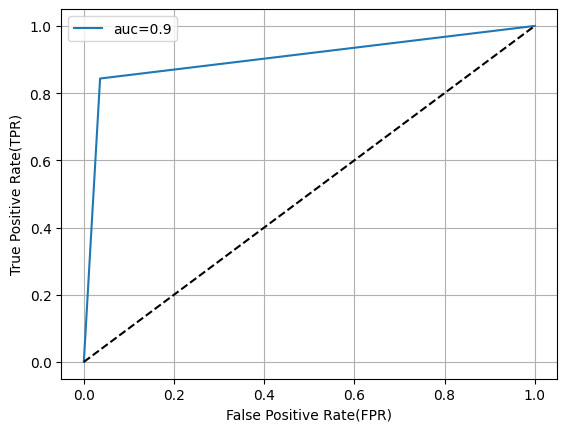

In [ ]:
metrics(rcv_knn.best_score_,preds_knn,y_test_cv,proba_knn)

**K-NN Classifier(Tfidf)**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score
knn = KNeighborsClassifier()
skf = StratifiedKFold(n_splits = 5)
knn = KNeighborsClassifier()
params_knn ={'n_neighbors': range(0,10),
             'weights': ['uniform','distance'],
             'metric':['manhattan','euclidean','cosine'],}
rcv_knn_tfidf = RandomizedSearchCV(knn, param_distributions=params_knn,cv=skf,scoring = 'accuracy')
rcv_knn_tfidf.fit(x_train_tfidf,y_train_tfidf)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=KNeighborsClassifier(),
                   param_distributions={'metric': ['manhattan', 'euclidean',
                                                   'cosine'],
                                        'n_neighbors': range(0, 10),
                                        'weights': ['uniform', 'distance']},
                   scoring='accuracy')

In [ ]:
rcv_knn_tfidf.best_params_

{'weights': 'uniform', 'n_neighbors': 7, 'metric': 'manhattan'}

In [ ]:
rcv_knn_tfidf.best_score_

0.8947911402473071

In [ ]:
final_model_knn_tfidf = knn.set_params(**rcv_knn_tfidf.best_params_)
final_model_knn_tfidf.fit(x_train_tfidf,y_train_tfidf)
preds_knn_tfidf= final_model_knn_tfidf.predict(x_test_tfidf)
proba_knn_tfidf= final_model_knn_tfidf.predict_proba(x_test_tfidf)

In [ ]:
y_test_bin = label_binarize(y_test_tfidf,classes= range(2))
y_test_bin.ravel().shape

(17024,)

train acuuracy: 0.8947911402473071
test acuuracy: 0.8966752819548872
Recall: 0.8857402198091835
Precision: 0.9043075907262275


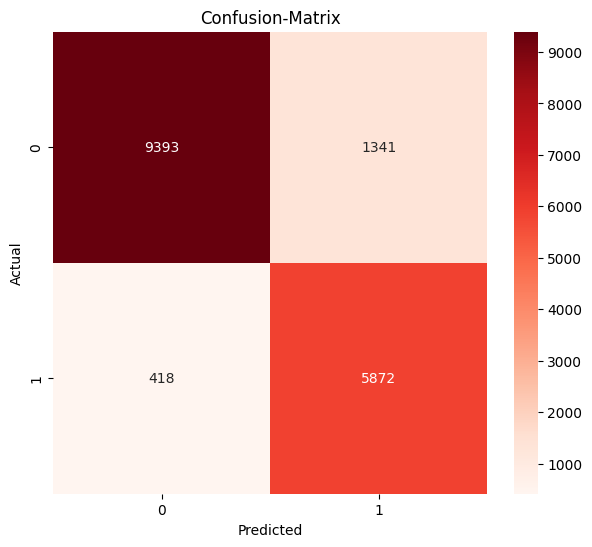

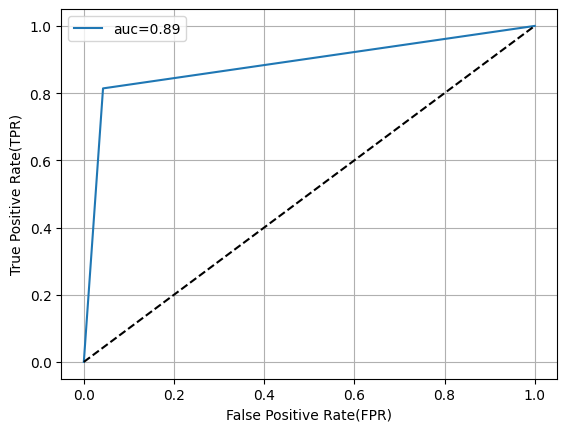

In [ ]:
metrics(rcv_knn_tfidf.best_score_,preds_knn_tfidf,y_test_tfidf,proba_knn_tfidf)

**Decision Tree(Bag of Words)**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
skf = StratifiedKFold(n_splits = 5)
dtc = DecisionTreeClassifier()

params_dtc ={'criterion':['gini', 'entropy', 'log_loss'],
         'splitter':['best'],
         'max_depth':range(3,8),
         'min_samples_split':[2,3,4,5],
         'min_weight_fraction_leaf':np.linspace(0,0.1, 10),
         'max_features':[None, 'sqrt', 'log2', 0.5],
         'ccp_alpha':[0.001,0.005,0.01,0.05]}

rcv_dt_cv = RandomizedSearchCV(dtc, param_distributions=params_dtc,cv=skf,scoring = 'accuracy')
rcv_dt_cv.fit(x_train_cv,y_train_cv)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(),
                   param_distributions={'ccp_alpha': [0.001, 0.005, 0.01, 0.05],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': range(3, 8),
                                        'max_features': [None, 'sqrt', 'log2',
                                                         0.5],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'min_weight_fraction_leaf': array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
       0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ]),
                                        'splitter': ['best']},
                   scoring='accuracy')

In [ ]:
final_model_dt_cv = dtc.set_params(**rcv_dt_cv.best_params_)
final_model_dt_cv.fit(x_train_cv,y_train_cv)
preds_dt_cv= final_model_dt_cv.predict(x_test_cv)
proba_dt_cv= final_model_dt_cv.predict_proba(x_test_cv)

train acuuracy: 0.8673496159713336
test acuuracy: 0.869125939849624
Recall: 0.8467735655207119
Precision: 0.904540347965076


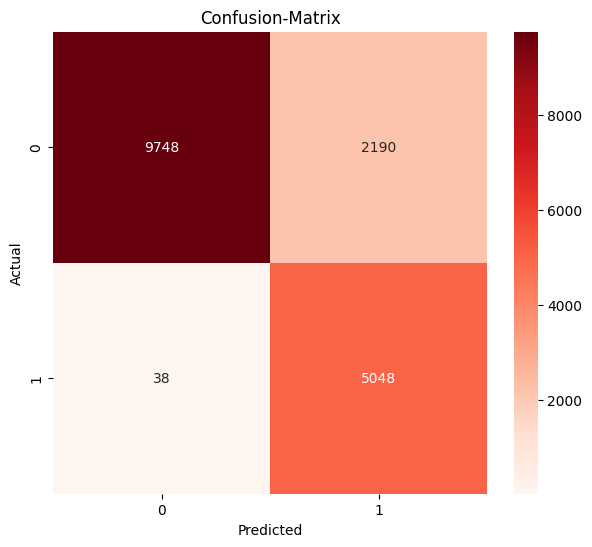

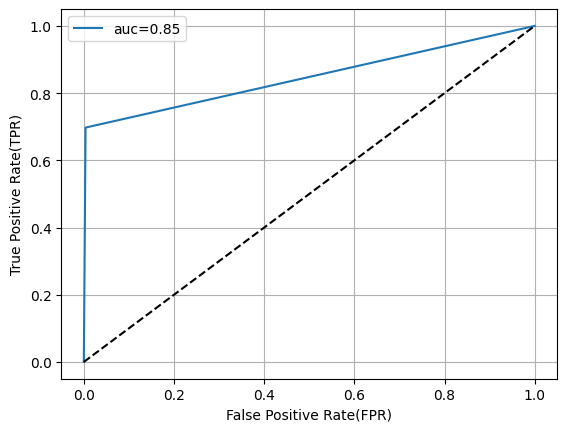

In [ ]:
metrics(rcv_dt_cv.best_score_,preds_dt_cv,y_test_cv,proba_dt_cv)

**Decision Tree (TfIdf)**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
skf = StratifiedKFold(n_splits = 5)
dtc = DecisionTreeClassifier(random_state=50)

params_dtc ={'criterion':['gini', 'entropy', 'log_loss'],
         'splitter':['best','random'],
         'max_depth':range(3,15),
         'min_samples_split':[2,3,4,5],
         'min_weight_fraction_leaf':np.linspace(0,0.1, 10),
         'max_features':[None, 'sqrt', 'log2', 0.5],
         'ccp_alpha':[0.0001,0.0005,0.001,0.005,0.01,0.05,]}

rcv_dt_tfidf = RandomizedSearchCV(dtc, param_distributions=params_dtc,cv=skf,scoring = 'accuracy')
rcv_dt_tfidf.fit(x_train_tfidf,y_train_tfidf)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(random_state=50),
                   param_distributions={'ccp_alpha': [0.0001, 0.0005, 0.001,
                                                      0.005, 0.01, 0.05],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': range(3, 15),
                                        'max_features': [None, 'sqrt', 'log2',
                                                         0.5],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'min_weight_fraction_leaf': array([0.        , 0.01111111, 0.02222222, 0.03333333, 0.04444444,
       0.05555556, 0.06666667, 0.07777778, 0.08888889, 0.1       ]),
                                        'splitter': ['best', 'random']},
                   scoring='accuracy')

In [ ]:
rcv_dt_tfidf.best_params_

{'splitter': 'random',
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 2,
 'max_features': 0.5,
 'max_depth': 10,
 'criterion': 'gini',
 'ccp_alpha': 0.001}

In [ ]:
final_model_dt_tfidf = dtc.set_params(**rcv_dt_tfidf.best_params_)
final_model_dt_tfidf.fit(x_train_tfidf,y_train_tfidf)
preds_dt_tfidf= final_model_dt_tfidf.predict(x_test_tfidf)
proba_dt_tfidf= final_model_dt_tfidf.predict_proba(x_test_tfidf)

train acuuracy: 0.895773022865534
test acuuracy: 0.8980850563909775
Recall: 0.8831819842266868
Precision: 0.9146946176722204


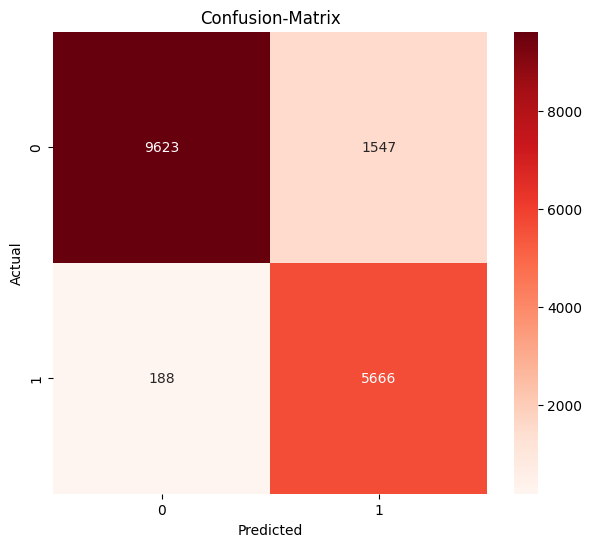

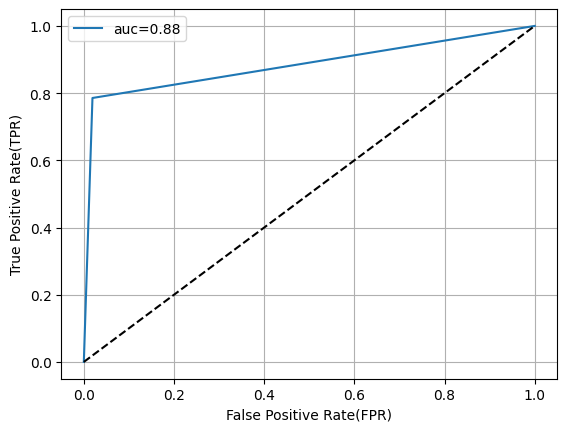

In [ ]:
metrics(rcv_dt_tfidf.best_score_,preds_dt_tfidf,y_test_tfidf,proba_dt_tfidf)

**SVM (Bag of Words)**

In [ ]:
from sklearn.svm import SVC
skf = StratifiedKFold(n_splits = 5)
svc = SVC(probability=True)

params_svc ={'C': range(1,5,2),
             'kernel':['linear']}

rcv_svm_cv = RandomizedSearchCV(svc,param_distributions=params_svc,cv=skf,scoring='accuracy' )
rcv_svm_cv.fit(x_train_cv,y_train_cv)



RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=SVC(probability=True),
                   param_distributions={'C': range(1, 5, 2),
                                        'kernel': ['linear']},
                   scoring='accuracy')

In [ ]:
final_model_svm_cv = svc.set_params(**rcv_svm_cv.best_params_)
final_model_svm_cv.fit(x_train_cv,y_train_cv)
preds_svm_cv= final_model_svm_cv.predict(x_test_cv)
proba_svm_cv= final_model_svm_cv.predict_proba(x_test_cv)

train acuuracy: 0.9310440515959101
test acuuracy: 0.9347979323308271
Recall: 0.9298504435934807
Precision: 0.9367934492099439


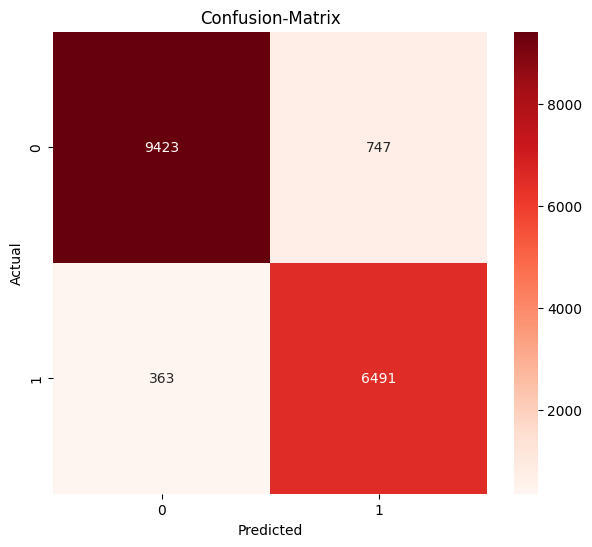

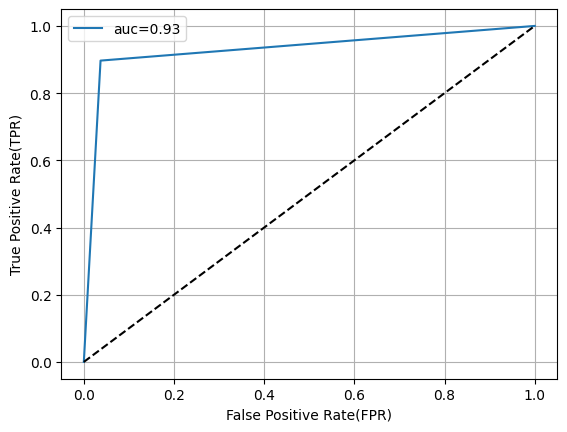

In [ ]:
metrics(rcv_svm_cv.best_score_,preds_svm_cv,y_test_cv,proba_svm_cv)

**SVM (TfIdf)**

In [ ]:
from sklearn.svm import SVC
skf = StratifiedKFold(n_splits = 5)
svc = SVC(probability=True)

params_svc ={'C': range(1,5,2),
             'kernel':['linear']}

rcv_svm_tfidf = RandomizedSearchCV(svc,param_distributions=params_svc,cv=skf,scoring='accuracy' )
rcv_svm_tfidf.fit(x_train_tfidf,y_train_tfidf)



RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=SVC(probability=True),
                   param_distributions={'C': range(1, 5, 2),
                                        'kernel': ['linear']},
                   scoring='accuracy')

In [ ]:
final_model_svm_tfidf = svc.set_params(**rcv_svm_tfidf.best_params_)
final_model_svm_tfidf.fit(x_train_tfidf,y_train_tfidf)
preds_svm_tfidf= final_model_svm_tfidf.predict(x_test_tfidf)
proba_svm_tfidf= final_model_svm_tfidf.predict_proba(x_test_tfidf)

train acuuracy: 0.9433044717680783
test acuuracy: 0.946546052631579
Recall: 0.9423712067686936
Precision: 0.948203272978626


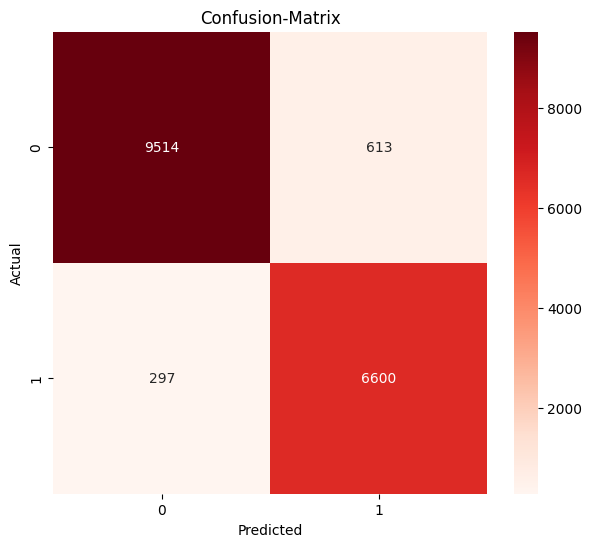

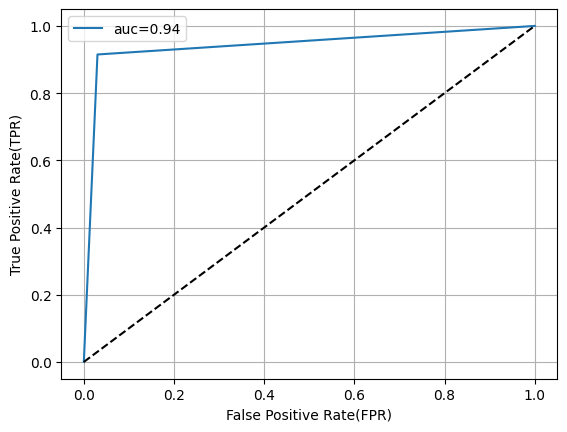

In [ ]:
metrics(rcv_svm_tfidf.best_score_,preds_svm_tfidf,y_test_tfidf,proba_svm_tfidf)

**Random Forest(Bag of Words)**

In [ ]:
skf = StratifiedKFold(n_splits = 5)
from sklearn.ensemble import RandomForestClassifier
rfc =  RandomForestClassifier()

params_rf = {'criterion':['gini','entropy'],
          'n_estimators': range(1,10),
          'max_features':[None, 'sqrt', 'log2', 0.5, 10],
#           'max_depth':range(3,8),
#           'min_samples_split':[2,3,4,5],
          'max_samples':[None, 0.3, 0.8, 0.9],
#           'ccp_alpha':np.linspace(0,0.015, 10)
          }

rcv_rf_cv = RandomizedSearchCV(rfc,param_distributions=params_rf,cv=skf,scoring='accuracy' )
rcv_rf_cv.fit(x_train_cv,y_train_cv)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': [None, 'sqrt', 'log2',
                                                         0.5, 10],
                                        'max_samples': [None, 0.3, 0.8, 0.9],
                                        'n_estimators': range(1, 10)},
                   scoring='accuracy')

In [ ]:
final_model_rf_cv = rfc.set_params(**rcv_rf_cv.best_params_)
final_model_rf_cv.fit(x_train_cv,y_train_cv)

preds_rf_cv= final_model_rf_cv.predict(x_test_cv)
proba_rf_cv= final_model_rf_cv.predict_proba(x_test_cv)

train acuuracy: 0.9227360434305082
test acuuracy: 0.924812030075188
Recall: 0.9184306242565763
Precision: 0.9280279503105591


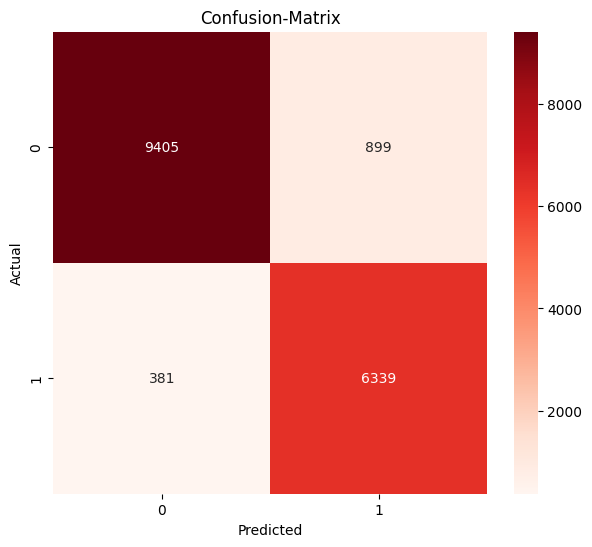

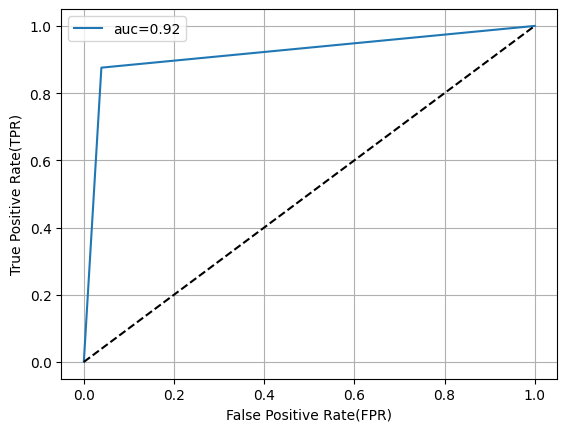

In [ ]:
metrics(rcv_rf_cv.best_score_,preds_rf_cv,y_test_cv,proba_rf_cv)

**Random Forest (TfIdf)**

In [ ]:
skf = StratifiedKFold(n_splits = 5)
rfc =  RandomForestClassifier()

params_rf = {'criterion':['gini','entropy'],
          'n_estimators': range(1,10),
          'max_features':[None, 'sqrt', 'log2', 0.5, 10],
#           'max_depth':range(3,8),
#           'min_samples_split':[2,3,4,5],
          'max_samples':[None, 0.3, 0.8, 0.9],
#           'ccp_alpha':np.linspace(0,0.015, 10)
          }

rcv_rf_tfidf = RandomizedSearchCV(rfc,param_distributions=params_rf,cv=skf,scoring='accuracy' )
rcv_rf_tfidf.fit(x_train_tfidf,y_train_tfidf)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': [None, 'sqrt', 'log2',
                                                         0.5, 10],
                                        'max_samples': [None, 0.3, 0.8, 0.9],
                                        'n_estimators': range(1, 10)},
                   scoring='accuracy')

In [ ]:
final_model_rf_tfidf = rfc.set_params(**rcv_rf_tfidf.best_params_)
final_model_rf_tfidf.fit(x_train_tfidf,y_train_tfidf)

preds_rf_tfidf= final_model_rf_tfidf.predict(x_test_tfidf)
proba_rf_tfidf= final_model_rf_tfidf.predict_proba(x_test_tfidf)

train acuuracy: 0.9357518615202579
test acuuracy: 0.9347979323308271
Recall: 0.9297372072076286
Precision: 0.93676301516294


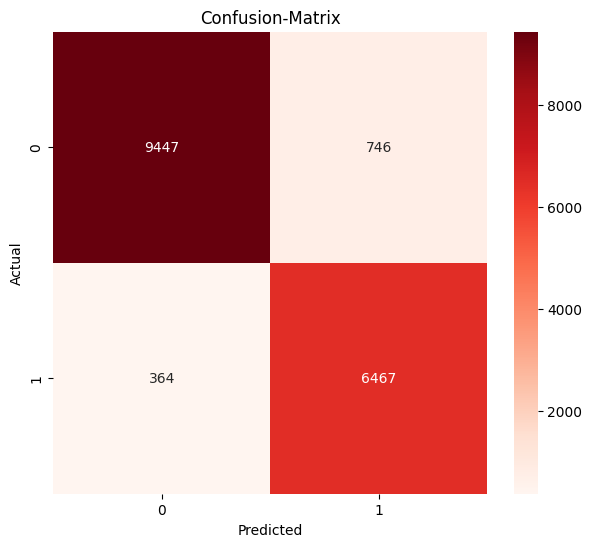

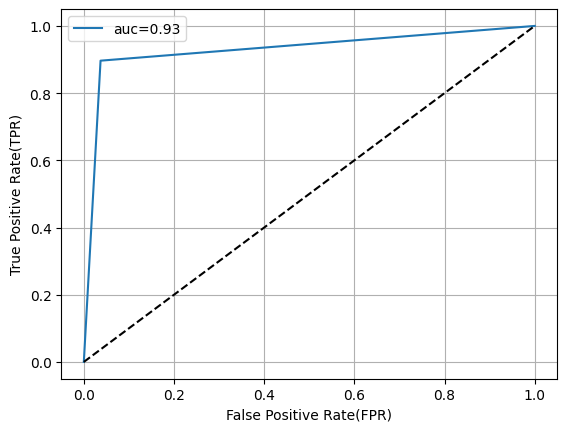

In [ ]:
metrics(rcv_rf_tfidf.best_score_,preds_rf_tfidf,y_test_tfidf,proba_rf_tfidf)